<a href="https://colab.research.google.com/github/meenub255/NXP_SEM_DEFECT/blob/main/TRAINING_CODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Full Knowledge Distillation Training Pipeline


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import copy
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, WeightedRandomSampler, random_split
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

# 1. Configuration & Hyperparameters

In [3]:
CONFIG = {
    "DATA_DIR": "/content/drive/MyDrive/Hackathon_Images/Augmented_Dataset_10x",
    "NUM_CLASSES": 8,
    "BATCH_SIZE": 32,
    "EPOCHS": 20,
    "LR": 1e-4,
    "TEACHER_MODEL": "swin_t",   # Swin Transformer Tiny
    "STUDENT_MODEL": "mobilenet_v3_small",
    "DISTILL_ALPHA": 0.5,        # Weight for Hard Label Loss (Student vs Truth)
    "DISTILL_TEMP": 7.0,         # Softening Temperature for Teacher
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu"
}
print(f"Running on device: {CONFIG['DEVICE']}")

Running on device: cuda


# 2. Dataset & Weighted Sampler (Imbalance Fix)


In [4]:
def get_dataloaders(data_dir):
    # Transforms (Minimal, since data is already augmented on disk)
    train_tf = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_tf = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    # Load Full Dataset
    full_dataset = ImageFolder(root=data_dir, transform=train_tf)

    # Split (80% Train, 20% Val)
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_ds, val_ds = random_split(full_dataset, [train_size, val_size])

    # Apply correct transform to val set (hacky but works for subset)
    val_ds.dataset.transform = val_tf
    # --- Weighted Random Sampler Logic ---
    # We calculate weights based on the *original* ImageFolder targets
    # Extract targets only for indices in train_ds
    train_indices = train_ds.indices
    train_targets = [full_dataset.targets[i] for i in train_indices]

    # Count samples per class
    class_counts = np.bincount(train_targets)
    class_weights = 1.0 / class_counts

    # Assign weight to each sample
    sample_weights = [class_weights[t] for t in train_targets]

    # Create Sampler
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )

    # Loaders
    train_loader = DataLoader(train_ds, batch_size=CONFIG["BATCH_SIZE"], sampler=sampler, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=CONFIG["BATCH_SIZE"], shuffle=False, num_workers=2)

    print(f"Classes: {full_dataset.classes}")
    return train_loader, val_loader, full_dataset.classes

# 3. Model Definitions

In [5]:
def get_teacher():
    print("Loading Teacher: Swin Transformer (Pretrained)...")
    model = models.swin_t(weights='DEFAULT')
    # Modify Head for 8 classes
    model.head = nn.Linear(model.head.in_features, CONFIG["NUM_CLASSES"])
    return model.to(CONFIG["DEVICE"])
def get_student():
    print("Loading Student: MobileNetV3-Small (Pretrained)...")
    model = models.mobilenet_v3_small(weights='DEFAULT')
    # Modify Head
    in_features = model.classifier[3].in_features
    model.classifier[3] = nn.Linear(in_features, CONFIG["NUM_CLASSES"])
    return model.to(CONFIG["DEVICE"])

# 4. Distillation Loss


In [6]:
class DistillationLoss(nn.Module):
    def __init__(self, alpha=0.5, temperature=7.0):
        super().__init__()
        self.alpha = alpha
        self.T = temperature
        self.hard_loss = nn.CrossEntropyLoss()
        self.soft_loss = nn.KLDivLoss(reduction="batchmean")
    def forward(self, student_logits, teacher_logits, labels):
        # 1. Hard Loss (Student vs Ground Truth)
        L_hard = self.hard_loss(student_logits, labels)

        # 2. Soft Loss (Student vs Teacher)
        # Soften probabilities with Temperature T
        soft_targets = nn.functional.softmax(teacher_logits / self.T, dim=1)
        soft_prob = nn.functional.log_softmax(student_logits / self.T, dim=1)

        L_soft = self.soft_loss(soft_prob, soft_targets) * (self.T ** 2)

        # Combine
        return self.alpha * L_hard + (1 - self.alpha) * L_soft


# 5. Training Loop


In [7]:
def train_distillation(teacher, student, train_loader, val_loader):
    criterion = DistillationLoss(alpha=CONFIG["DISTILL_ALPHA"], temperature=CONFIG["DISTILL_TEMP"])
    optimizer = optim.AdamW(student.parameters(), lr=CONFIG["LR"])
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG["EPOCHS"])

    teacher.eval()

    best_acc = 0.0

    for epoch in range(CONFIG["EPOCHS"]):
        student.train()
        running_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{CONFIG['EPOCHS']}")

        for images, labels in pbar:
            images, labels = images.to(CONFIG['DEVICE']), labels.to(CONFIG['DEVICE'])

            # Forward Pass
            with torch.no_grad():
                teacher_logits = teacher(images)

            student_logits = student(images)

            # Loss
            loss = criterion(student_logits, teacher_logits, labels)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Metrics
            running_loss += loss.item()
            _, predicted = torch.max(student_logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            pbar.set_postfix({'loss': running_loss/len(pbar), 'acc': 100*correct/total})

        scheduler.step()

        # Validation
        val_acc = evaluate(student, val_loader)
        print(f"Epoch {epoch+1} finished. Val Acc: {val_acc:.2f}%")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(student.state_dict(), "best_student_model.pth")
            print("Saved Best Model!")
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(CONFIG['DEVICE']), labels.to(CONFIG['DEVICE'])
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# 6. Main Execution


In [8]:
if __name__ == "__main__":
    # 1. Setup Data
    train_dl, val_dl, classes = get_dataloaders(CONFIG["DATA_DIR"])

    # 2. Setup Models
    teacher_model = get_teacher()
    student_model = get_student()

    # 3. Train
    print("\nStarting Distillation Training...")
    train_distillation(teacher_model, student_model, train_dl, val_dl)

    print("\nTraining Complete. Best model saved as 'best_student_model.pth'")

Classes: ['CMP', 'LER', 'bridge', 'clean sem images', 'cracks', 'opens', 'vias']
Loading Teacher: Swin Transformer (Pretrained)...
Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth


100%|██████████| 108M/108M [00:00<00:00, 141MB/s] 


Loading Student: MobileNetV3-Small (Pretrained)...
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 135MB/s]


Starting Distillation Training...


Epoch 1/20:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1 finished. Val Acc: 67.36%
Saved Best Model!


Epoch 2/20:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2 finished. Val Acc: 80.83%
Saved Best Model!


Epoch 3/20:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3 finished. Val Acc: 87.82%
Saved Best Model!


Epoch 4/20:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4 finished. Val Acc: 93.01%
Saved Best Model!


Epoch 5/20:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5 finished. Val Acc: 94.04%
Saved Best Model!


Epoch 6/20:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 6 finished. Val Acc: 96.37%
Saved Best Model!


Epoch 7/20:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 7 finished. Val Acc: 97.67%
Saved Best Model!


Epoch 8/20:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 8 finished. Val Acc: 98.45%
Saved Best Model!


Epoch 9/20:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 9 finished. Val Acc: 98.70%
Saved Best Model!


Epoch 10/20:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 10 finished. Val Acc: 98.70%


Epoch 11/20:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 11 finished. Val Acc: 98.70%


Epoch 12/20:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 12 finished. Val Acc: 98.96%
Saved Best Model!


Epoch 13/20:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 13 finished. Val Acc: 98.70%


Epoch 14/20:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 14 finished. Val Acc: 98.45%


Epoch 15/20:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 15 finished. Val Acc: 98.45%


Epoch 16/20:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 16 finished. Val Acc: 98.45%


Epoch 17/20:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 17 finished. Val Acc: 98.70%


Epoch 18/20:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 18 finished. Val Acc: 98.45%


Epoch 19/20:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 19 finished. Val Acc: 98.70%


Epoch 20/20:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 20 finished. Val Acc: 98.70%

Training Complete. Best model saved as 'best_student_model.pth'


# Testing

Loading Student Model from best_student_model.pth...
Running Inference...

       TEST RESULTS
                  precision    recall  f1-score   support

             CMP       1.00      1.00      1.00       770
             LER       1.00      1.00      1.00         5
          bridge       0.99      1.00      0.99       283
clean sem images       1.00      0.95      0.98        21
          cracks       1.00      1.00      1.00       290
           opens       1.00      1.00      1.00       539
            vias       1.00      1.00      1.00        22

        accuracy                           1.00      1930
       macro avg       1.00      0.99      1.00      1930
    weighted avg       1.00      1.00      1.00      1930



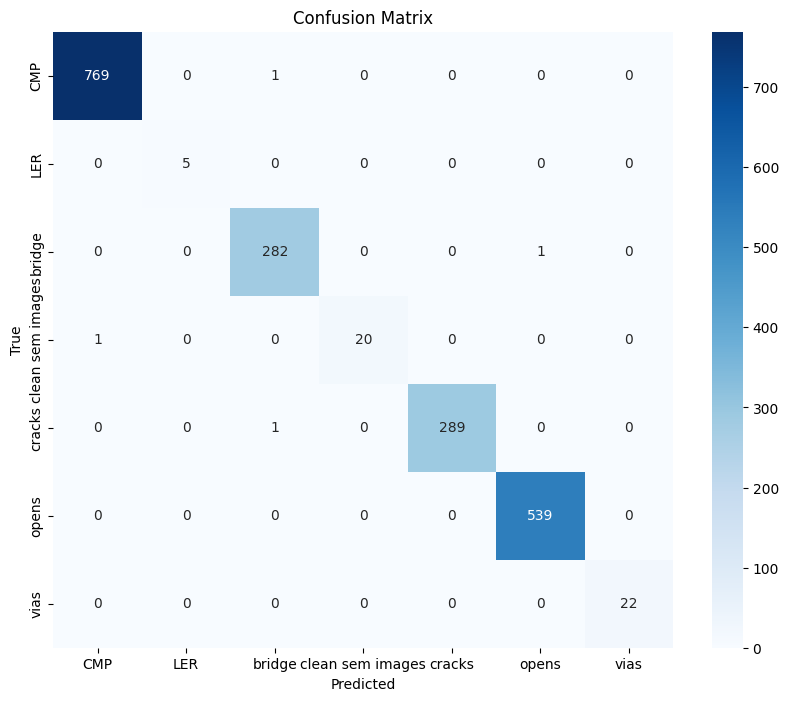

In [9]:
import torch
import torch.nn as nn
import torchvision.transforms as T
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ==========================================
# 1. Configuration (Must Match Training)
# ==========================================
TEST_CONFIG = {
    "DATA_DIR": "/content/drive/MyDrive/Hackathon_Images/Augmented_Dataset_10x",
    "MODEL_PATH": "best_student_model.pth",
    "NUM_CLASSES": 8,
    "BATCH_SIZE": 32,
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu"
}

# ==========================================
# 2. Load Test Data
# ==========================================
def get_test_loader(data_dir):
    # Same transforms as Validation
    test_tf = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load Dataset
    # NOTE: Ideally, use a separate 'test' folder.
    # If using the same folder as training, using 'val_ds' logic from your training script is better.
    # For now, we load the whole folder as a proxy test (or point DATA_DIR to a specific test folder)
    test_dataset = ImageFolder(root=data_dir, transform=test_tf)

    test_loader = DataLoader(test_dataset, batch_size=TEST_CONFIG["BATCH_SIZE"], shuffle=False, num_workers=2)

    return test_loader, test_dataset.classes

# ==========================================
# 3. Load Student Model
# ==========================================
def load_student_model(model_path, num_classes):
    print(f"Loading Student Model from {model_path}...")
    model = models.mobilenet_v3_small(weights=None) # No init weights needed, we load checkpt

    # Recreate Head (Must match training structure)
    in_features = model.classifier[3].in_features
    model.classifier[3] = nn.Linear(in_features, num_classes)

    # Load State Dict
    model.load_state_dict(torch.load(model_path, map_location=TEST_CONFIG["DEVICE"]))
    model.to(TEST_CONFIG["DEVICE"])
    model.eval()
    return model

# ==========================================
# 4. Evaluation Loop
# ==========================================
def run_test(model, test_loader, classes):
    all_preds = []
    all_labels = []

    print("Running Inference...")
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(TEST_CONFIG["DEVICE"])
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    # --- Metrics ---
    print("\n" + "="*30)
    print("       TEST RESULTS")
    print("="*30)

    # 1. Classification Report
    print(classification_report(all_labels, all_preds, target_names=classes))

    # 2. Confusion Matrix Plot
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# ==========================================
# 5. Run
# ==========================================
if __name__ == "__main__":
    # If you want to test on the Validation set specifically (recommended),
    # you might need to copy the 'get_dataloaders' logic from your training script
    # and just use the returned 'val_dl'.
    # Below assumes you have a directory you want to test on.

    test_loader, class_names = get_test_loader(TEST_CONFIG["DATA_DIR"])

    student = load_student_model(TEST_CONFIG["MODEL_PATH"], TEST_CONFIG["NUM_CLASSES"])

    run_test(student, test_loader, class_names)